# Assignment 2

## Authors 
- Enzo Benoit-Jeannin
- Sasha Denouvilliez-Pech

# Part1: Tabular RL

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Boltzmann exploration
#  https://github.com/mpatacchiola/dissecting-reinforcement-learning/blob/8b418dfaa091675b2f100814c5543b0f2b10217a/src/6/multi-armed-bandit/boltzman_agent_bandit.py#L43
def softmax(x, temp):
    # for numerical stability, subtract the maximum value from x
    power = np.true_divide(x - np.max(x), temp)
    return np.exp(power) / np.sum(np.exp(power))

def epsilon_soft(q_values, epsilon):
    num_actions = len(q_values)
    probs = np.ones(num_actions) * epsilon / num_actions
    best_action = np.argmax(q_values)
    probs[best_action] += (1.0 - epsilon)
    return probs

In [ ]:
class Sarsa:
    def __init__(self, env, alpha, gamma, temp):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        return

    def select_action(self, s, greedy=False):
        # write your solution here
        if greedy:
            # if finished training, then choose the optimal policy
            return np.argmax(self.Q[s, :])
        else:
            return np.random.choice(
                self.env.action_space.n, p=softmax(self.Q[s, :], self.temp)
            )

    def update(self, s, a, r, s_prime, a_prime, done):
        # What to do with the done flag?
        q = self.Q[s, a]
        q_prime = self.Q[s_prime, a_prime]
        self.Q[s, a] += self.alpha * (r + self.gamma * q_prime - q)


class ExpectedSarsa:
    def __init__(self, env, alpha, gamma, temp):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        return

    # Should it be the same as the one in Sarsa?
    def select_action(self, s, greedy=False):
        if greedy:
            # if finished training, then choose the optimal policy
            return np.argmax(self.Q[s, :])
        else:
            return np.random.choice(
                self.env.action_space.n, p=softmax(self.Q[s, :], self.temp)
            )

    def update(self, s, a, r, s_prime, a_prime, done):
        # What to do with the done flag and a_prime?
        q = self.Q[s, a]
        expected_q = np.dot(softmax(self.Q[s_prime, :], self.temp), self.Q[s_prime, :])
        self.Q[s, a] += self.alpha * (r + self.gamma * expected_q - q)


# bonus question, optional
class Hybrid_Sarsa_Q:
    def __init__(self, env, alpha, epsilon, gamma, theta):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.theta = theta # Name the new parameter for the hybrid model theta (different from the alpha given in the question as we already have alpha)
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        return

    def select_action(self, s, greedy=False):
        # write your solution here
        if greedy:
            # if finished training, then choose the optimal policy
            return np.argmax(self.Q[s, :])
        else:
            return np.random.choice(
                self.env.action_space.n, p=epsilon_soft(self.Q[s, :], self.epsilon)
            )

    def update(self, s, a, r, s_prime, a_prime, done):
        expected_q = np.sum(epsilon_soft(self.Q[s_prime], self.epsilon) * self.Q[s_prime])
        q_function = np.max(self.Q[s_prime])
        self.Q[s,a] = self.Q[s, a] + self.alpha * (r + self.gamma * ((1 - self.theta) * q_function + self.theta * expected_q) - self.Q[s,a])
        return

In [ ]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(6)
State space: Discrete(500)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# https://github.com/PacktPublishing/Hands-On-Reinforcement-Learning-with-Python/blob/master/Chapter05/5.7%20Taxi%20Problem%20-%20SARSA.ipynb
def run_episode(agent, env, greedy=False):
    cumul_reward = 0
    s = env.reset()
    a = agent.select_action(s, greedy=greedy)
    while True:
        # env.render()
        s_prime, r, done, _ = env.step(a)
        a_prime = agent.select_action(s_prime, greedy=greedy)
        agent.update(s, a, r, s_prime, a_prime, done)
        s = s_prime
        a = a_prime
        cumul_reward += r
        if done:  # Taxi drops off passenger or length of episode is 200
            break
    return cumul_reward

# If learning_curve is true, returns 500 cumulative rewards for test episodes only
# otherwise returns the cumulative rewards of the last segment (10 train & 1 test)
def run_trial(agent, env, learning_curve=False):
    segments = 500
    returns = []
    for segment in range(segments):
        for episode in range(10):
            r = run_episode(agent, env)
            if not learning_curve and segment == segments - 1:
                returns.append(r)
        # Test episode
        r = run_episode(agent, env, greedy=True)
        if learning_curve or segment == segments - 1:
            returns.append(r)
    return np.asarray(returns)

The experiments consist of testing every combination of two hyperparameters, the learning rate α and the temperature τ, from the set \{ 0.01, 0.1, 0.5, 0.9, 0.99 \}. Those values were chosen for a few reasons. First, default values for α are generally pretty small in ML, 0.01 or 0.1 from [Practical recommendations for gradient-based training of deep architectures](https://arxiv.org/abs/1206.5533). In the context of RL, wider exploration for this parameter could provide valuable insights into a good balance between accuracy and speed of convergence. Second, for the Boltzmann exploration temperature, values from 1.0 to 0.01 are tested as previously done in [Learning-Driven Exploration for Reinforcement Learning](https://arxiv.org/pdf/1906.06890.pdf#:~:text=In%20Boltzmann%20exploration%2C%20the%20temperature,%2C%20%CE%B5%20%3D%200.01%20is%20used). Effectively, higher temperature values will lead to a random policy and therefore more exploration, whereas smaller values will lead to a greedy policy as explained in [Using Boltzmann distribution as the exploration policy in TensorFlow-agent reinforcement learning models](https://mikulskibartosz.name/using-boltzmann-distribution-as-exploration-policy-in-tensorflow-agent). Finally, as mentioned on [Ed](https://edstem.org/us/courses/51330/discussion/4326882), evaluating hyperparameters on a "log scale" could help identify general behaviours. It is also worth noting the discout rate γ was fixed to 0.9 for all experiments.

As described in the instructions, each experiment for a hyperparameter combination consists of 10 independent trials. Each trial consists of 500 segments and each segments consists of 10 training episodes and 1 testing episode. Experiments are performed for both Sarsa and Expected Sarsa models.

In [ ]:
# function that runs each hyperparameter setting experiments
alphas = [0.01, 0.1, 0.5, 0.9, 0.99]
gamma = 0.9
temps = [0.01, 0.1, 0.5, 0.9, 0.99]

# For each experiment, i.e. alpha-temp combination contains:
# 10 independent trial, where each trials contains 11 cumulative reward values:
# 10 training and 1 test for final segment
sarsa_experiments = []
expected_sarsa_experiments = []

for alpha in alphas:
    for temp in temps:
        sarsa_returns = []
        expected_sarsa_returns = []
        for _ in range(10):
            agent = Sarsa(env, alpha, gamma, temp)
            sarsa_returns.append(run_trial(agent, env))
            del agent
            agent = ExpectedSarsa(env, alpha, gamma, temp)
            expected_sarsa_returns.append(run_trial(agent, env))
            del agent
        sarsa_experiments.append(np.asarray(sarsa_returns))
        expected_sarsa_experiments.append(np.asarray(expected_sarsa_returns))

sarsa_experiments = np.asarray(sarsa_experiments)
expected_sarsa_experiments = np.asarray(expected_sarsa_experiments)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### Plot the graphs

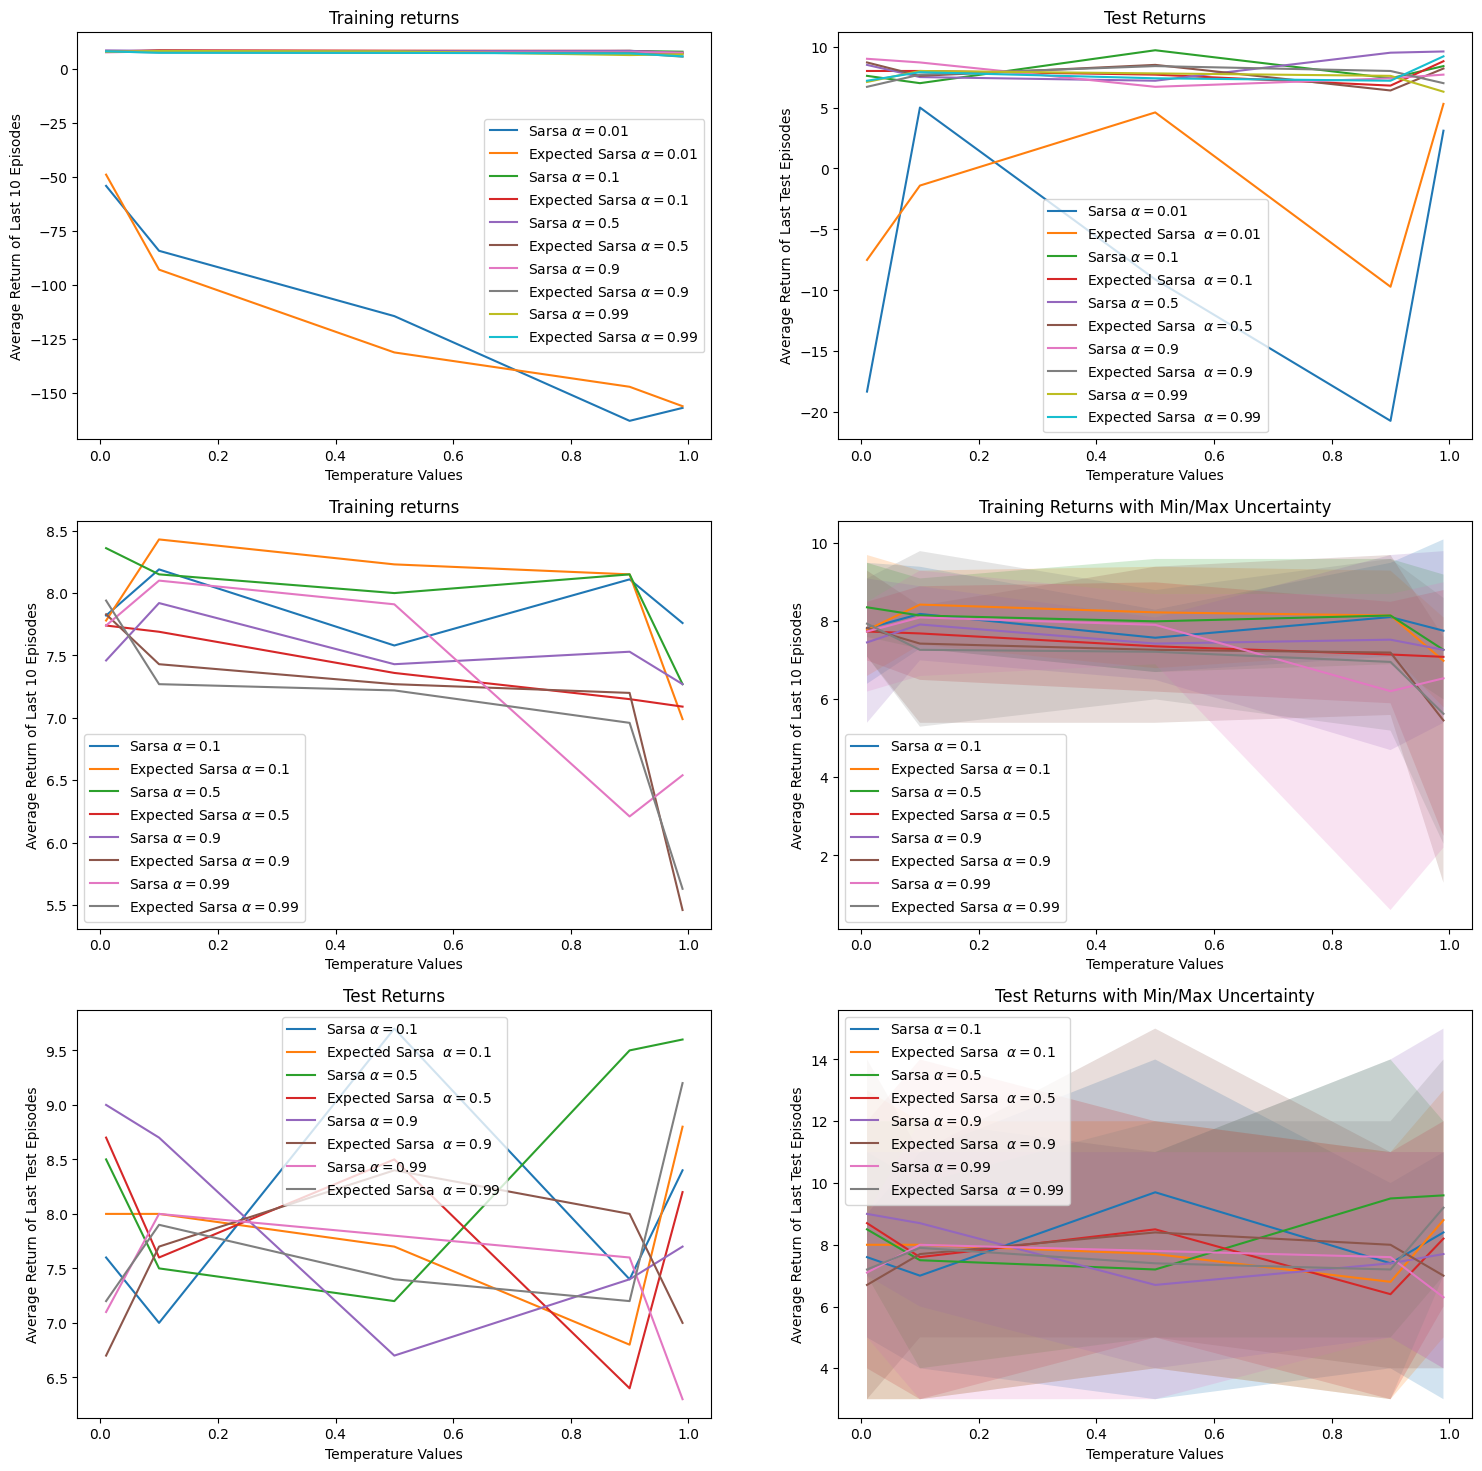

In [ ]:
sarsa_experiments = np.asarray(sarsa_experiments)
expected_sarsa_experiments = np.asarray(expected_sarsa_experiments)

sarsa_experiments_avg_train = np.mean(
    np.mean(sarsa_experiments[:, :, :10], axis=2), axis=1
)
sarsa_experiments_max_train = np.max(
    np.mean(sarsa_experiments[:, :, :10], axis=2), axis=1
)
sarsa_experiments_min_train = np.min(
    np.mean(sarsa_experiments[:, :, :10], axis=2), axis=1
)

expected_sarsa_experiments_avg_train = np.mean(
    np.mean(expected_sarsa_experiments[:, :, :10], axis=2), axis=1
)
expected_sarsa_experiments_max_train = np.max(
    np.mean(expected_sarsa_experiments[:, :, :10], axis=2), axis=1
)
expected_sarsa_experiments_min_train = np.min(
    np.mean(expected_sarsa_experiments[:, :, :10], axis=2), axis=1
)

sarsa_experiments_avg_test = np.mean(sarsa_experiments[:, :, 10], axis=1)
sarsa_experiments_max_test = np.max(sarsa_experiments[:, :, 10], axis=1)
sarsa_experiments_min_test = np.min(sarsa_experiments[:, :, 10], axis=1)

expected_sarsa_experiments_avg_test = np.mean(
    expected_sarsa_experiments[:, :, 10], axis=1
)
expected_sarsa_experiments_max_test = np.max(
    expected_sarsa_experiments[:, :, 10], axis=1
)
expected_sarsa_experiments_min_test = np.min(
    expected_sarsa_experiments[:, :, 10], axis=1
)


fig, ax = plt.subplots(3, 2, figsize=(18, 18))
n = 5

# Training returns without uncertainty with alpha = 0.01
for i in range(len(alphas)):
    alpha = alphas[i]
    ax[0][0].plot(
        temps,
        sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"Sarsa $\alpha = %s$" % alpha,
    )
    ax[0][0].plot(
        temps,
        expected_sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"Expected Sarsa $\alpha = %s$" % alpha,
    )

ax[0][0].set_title("Training returns")
ax[0][0].set_xlabel("Temperature Values")
ax[0][0].set_ylabel("Average Return of Last 10 Episodes")
ax[0][0].legend()

# Test returns without uncertainty with alpha = 0.01
for i in range(len(alphas)):
    alpha = alphas[i]
    ax[0][1].plot(
        temps,
        sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"Sarsa $\alpha = %s$" % alpha,
    )
    ax[0][1].plot(
        temps,
        expected_sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"Expected Sarsa  $\alpha = %s$" % alpha,
    )

ax[0][1].set_title("Test Returns")
ax[0][1].set_xlabel("Temperature Values")
ax[0][1].set_ylabel("Average Return of Last Test Episodes")
ax[0][1].legend()

# Training returns without uncertainty
for i in range(1, len(alphas)):
    alpha = alphas[i]
    ax[1][0].plot(
        temps,
        sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"Sarsa $\alpha = %s$" % alpha,
    )
    ax[1][0].plot(
        temps,
        expected_sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"Expected Sarsa $\alpha = %s$" % alpha,
    )

ax[1][0].set_title("Training returns")
ax[1][0].set_xlabel("Temperature Values")
ax[1][0].set_ylabel("Average Return of Last 10 Episodes")
ax[1][0].legend()

# Training returns with uncertainty
for i in range(1, len(alphas)):
    alpha = alphas[i]
    ax[1][1].plot(
        temps,
        sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"Sarsa $\alpha = %s$" % alpha,
    )
    ax[1][1].fill_between(
        temps,
        sarsa_experiments_min_train[n * i : n * (i + 1)],
        sarsa_experiments_max_train[n * i : n * (i + 1)],
        alpha=0.2,
    )
    ax[1][1].plot(
        temps,
        expected_sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"Expected Sarsa $\alpha = %s$" % alpha,
    )
    ax[1][1].fill_between(
        temps,
        expected_sarsa_experiments_min_train[n * i : n * (i + 1)],
        expected_sarsa_experiments_max_train[n * i : n * (i + 1)],
        alpha=0.2,
    )

ax[1][1].set_title("Training Returns with Min/Max Uncertainty")
ax[1][1].set_xlabel("Temperature Values")
ax[1][1].set_ylabel("Average Return of Last 10 Episodes")
ax[1][1].legend()

# Test returns without uncertainty
for i in range(1, len(alphas)):
    alpha = alphas[i]
    ax[2][0].plot(
        temps,
        sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"Sarsa $\alpha = %s$" % alpha,
    )
    ax[2][0].plot(
        temps,
        expected_sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"Expected Sarsa  $\alpha = %s$" % alpha,
    )

ax[2][0].set_title("Test Returns")
ax[2][0].set_xlabel("Temperature Values")
ax[2][0].set_ylabel("Average Return of Last Test Episodes")
ax[2][0].legend()

# Test returns with uncertainty
for i in range(1, len(alphas)):
    alpha = alphas[i]
    ax[2][1].plot(
        temps,
        sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"Sarsa $\alpha = %s$" % alpha,
    )
    ax[2][1].fill_between(
        temps,
        sarsa_experiments_min_test[n * i : n * (i + 1)],
        sarsa_experiments_max_test[n * i : n * (i + 1)],
        alpha=0.2,
    )
    ax[2][1].plot(
        temps,
        expected_sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"Expected Sarsa  $\alpha = %s$" % alpha,
    )
    ax[2][1].fill_between(
        temps,
        expected_sarsa_experiments_min_test[n * i : n * (i + 1)],
        expected_sarsa_experiments_max_test[n * i : n * (i + 1)],
        alpha=0.2,
    )

ax[2][1].set_title("Test Returns with Min/Max Uncertainty")
ax[2][1].set_xlabel("Temperature Values")
ax[2][1].set_ylabel("Average Return of Last Test Episodes")
ax[2][1].legend()

plt.show()

### Graph Analysis

As seen in the first row of graphs, both models with α = 0.01 perform very poorly suggesting too slow learning given the 500 segments. This could potentially be improved with longer training, but those models are therefore discarded to focus on the others. This is why we choose to plot the training and test returns under without these two models.

The second row of graphs shows the average training performance of the last segment. For Expected Sarsa, smaller $\alpha$ values of around 0.1 yield better results regardless of the temperature values. For Sarsa, the behavior is less clear with respect to $\alpha$ altough it seems like $\alpha$ values of around 0.1 and 0.5 also yield the overall best average returns. Although mostly prevalent for Expected Sarsa, performance generally decreases as temperature increases. More greedy policies seem to yield better training performances. Additionnally, higher temperatures seem to provide higher uncertainty as depcited by the max and min uncertainty graph on the training.

The third row of graphs shows the average test performance of the last segment. Overall test performance is much more volatile than the training one. Spikes of performance can be observed on both extremities differentiating in temperature. It is important to note that the stronger uncertainties now seem to occur with temperature values of around 0.5 which differs from our conclusion on the training results.


### Learning curves

Therefore, based on the results of the previous experiemnt, we consider the best parameter settings for Sarsa as $\alpha = 0.5, \gamma = 0.9$, and $\tau = 0.9$. As can be seen in the graphs, this combination leads to the most consistent training and testing performances. More precisely, α = 0.5 is the best training value combination and both training and test maximums are at τ = 0.9. For Expected Sarsa, the best parameter settings are α = 0.5, γ = 0.9, and τ = 0.01. Again in terms of consistency of performance between training and testing. More precisely, α = 0.5 is the second best training value combination and both training and test maximums are at τ = 0.01.

As both combinations have α = 0.5, it seems to confirm that a compromise between convergence speed and accuracy is required. Furthermore, the choice of τ = 0.9 for Sarsa might indicate a need for more exploration during training to compensate for the higher variance induced by the update rule (max function). Similarly, the choice of τ = 0.9 for Expected Sarsa might indicate that this problem is less prevalent as expected by the update rule (expectation).





In [ ]:
# Learning Curves
sarsa_returns = []
expected_sarsa_returns = []
for _ in range(10):
    # Best Sarsa combination
    agent = Sarsa(env, alpha=0.5, gamma=0.9, temp=0.9)
    sarsa_returns.append(run_trial(agent, env, learning_curve=True))
    del agent
    # Best Expected Sarsa combination
    agent = ExpectedSarsa(env, alpha=0.5, gamma=0.9, temp=0.01)
    expected_sarsa_returns.append(run_trial(agent, env, learning_curve=True))
    del agent

sarsa_returns = np.asarray(sarsa_returns)
expected_sarsa_returns = np.asarray(expected_sarsa_returns)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


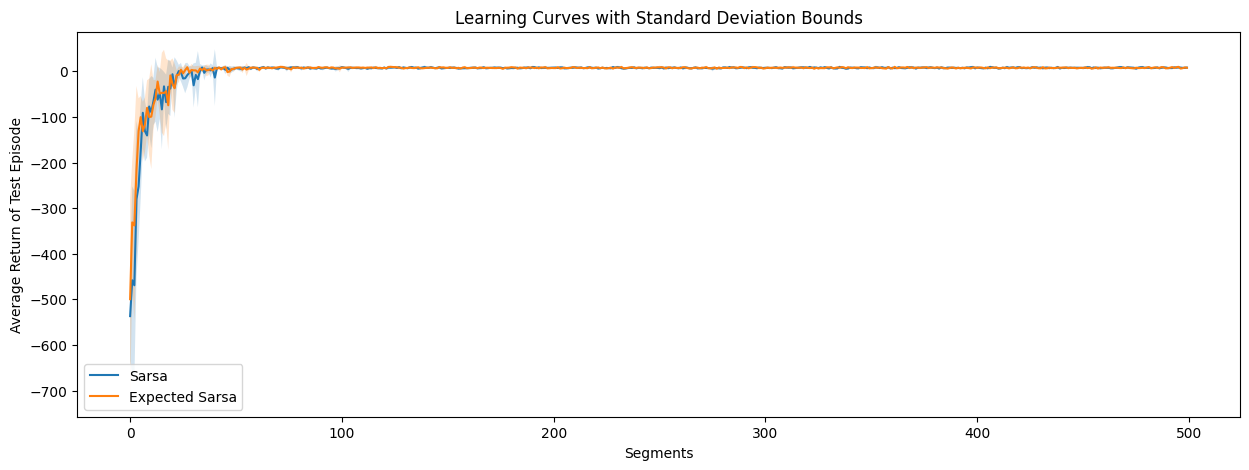

In [ ]:
sarsa_returns_avg = np.mean(sarsa_returns, axis=0)
sarsa_returns_std = np.std(sarsa_returns, axis=0)

expected_sarsa_returns_avg = np.mean(expected_sarsa_returns, axis=0)
expected_sarsa_returns_std = np.std(expected_sarsa_returns, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(sarsa_returns_avg, label=r"Sarsa")
ax.fill_between(
    range(len(sarsa_returns_avg)),
    sarsa_returns_avg - sarsa_returns_std,
    sarsa_returns_avg + sarsa_returns_std,
    alpha=0.2,
)
ax.plot(expected_sarsa_returns_avg, label=r"Expected Sarsa")
ax.fill_between(
    range(len(expected_sarsa_returns_avg)),
    expected_sarsa_returns_avg - expected_sarsa_returns_std,
    expected_sarsa_returns_avg + expected_sarsa_returns_std,
    alpha=0.2,
)

ax.set_title("Learning Curves with Standard Deviation Bounds")
ax.set_xlabel("Segments")
ax.set_ylabel("Average Return of Test Episode")
ax.legend()

plt.show()

The previous graph shows the average test performance over the 500 segments for each model given their best parameter settings. It also shows the standard deviation of the 10 trials at each segment. Both models clearly converge with some important volatility in the first segments (up to around 50). Expected Sarsa converges faster than Sarsa and seems to stabilize sooner.

# Part 2:

**Bellman equation and dynamic programming**

Suppose we are in an MDP and the reward function has the structure $ r(s, a) = \alpha r_1(s, a) + \beta r_2(s, a) $ where $ \alpha, \beta $ are real numbers. In this question, we investigate whether we could solve the problems defined by reward functions $ r_1 $ and $ r_2 $ independently and then somehow combine them linearly to solve the problem defined by $ r $. Assume the discounted setting with a given discount $ \gamma $.

a) Suppose you are given the action-value functions $ q^{\pi}_1 $ and $ q^{\pi}_2 $ corresponding to the action-value function of an arbitrary, fixed policy $ \pi $ under the two reward functions. Using the Bellman equation, show if it is possible or not to combine these value functions in a simple manner (linear) to obtain $ q^{\pi} $ corresponding to reward function $ r $.

b) Suppose you are given the optimal action-value functions $ q_1^* $ and $ q_2^* $. Using the Bellman equation, explain if it is possible or not to combine these value functions in a simple manner (linear) to obtain $ q^* $ which optimizes reward function $ r $.


**Solution:**

a) We consider an MDP with a reward function structured as a linear combination of two independent reward functions $r_1$ and $r_2$, and we aim to investigate the possibility of linearly combining action-value functions corresponding to these reward functions to obtain an action-value function for the combined reward function.

Given the action-value functions $q^{\pi}_1$ and $q^{\pi}_2$ for policy $\pi$ under the reward functions $r_1(s, a)$ and $r_2(s, a)$, respectively, we have:

\begin{align*}
q^{\pi}_1(s,a) &= \mathbb{E}_{\pi} \left\{ \sum_{k=0}^{\infty} \gamma^k r_1(S_{t+k+1}, A_{t+k+1}) | S_t = s, A_t = a \right\} \\
q^{\pi}_2(s,a) &= \mathbb{E}_{\pi} \left\{ \sum_{k=0}^{\infty} \gamma^k r_2(S_{t+k+1}, A_{t+k+1}) | S_t = s, A_t = a \right\}
\end{align*}

The reward function $r$ is a linear combination of $r_1$ and $r_2$ with real coefficients $\alpha$ and $\beta$: $r(s, a) = \alpha r_1(s, a) + \beta r_2(s, a)$. Our goal is to determine if $q^{\pi}(s,a)$, the action-value function for the combined reward function $r$, can be obtained by a simple linear combination of $q^{\pi}_1(s,a)$ and $q^{\pi}_2(s,a)$.

We know by definition that the action-value function $ q^{\pi} $ for an arbitrary, fixed policy $ \pi $ under the reward function $ r $ can be defined as:
\begin{equation*}
q^{\pi}(s,a) = \mathbb{E}_\pi [ G_t | S_t = s, A_t = a ]
\end{equation*}

We also know that $ G_t $ is equal to the following by definition:
$
G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$
where $ R_{t+k+1} = \alpha R_{t+k+1}^{(1)} + \beta R_{t+k+1}^{(2)} $ by the property of our reward function. Indeed, given the structure of $ r(s, a) $, the rewards $ R_{t+k+1} $ at future timesteps can also be expressed as a linear combination of rewards under $ r_1 $ and $ r_2 $.

Then $ q^{\pi}(s,a) $ can be rewritten as:
\begin{align*}
q^{\pi}(s,a) &= \mathbb{E}_\pi \left[ \sum_{k=0}^{\infty} \gamma^k (\alpha R_{t+k+1}^{(1)} + \beta R_{t+k+1}^{(2)}) | S_t = s, A_t = a \right] \\
&= \mathbb{E}_\pi \left[ \sum_{k=0}^{\infty} \gamma^k (\alpha R_{t+k+1}^{(1)}) | S_t = s, A_t = a \right] + \mathbb{E}_\pi \left[ \sum_{k=0}^{\infty} \gamma^k (\beta R_{t+k+1}^{(2)}) | S_t = s, A_t = a \right] \\
&= \alpha \mathbb{E}_\pi \left[ \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}^{(1)} | S_t = s, A_t = a \right] + \beta \mathbb{E}_\pi \left[ \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}^{(2)} | S_t = s, A_t = a \right] \\
&= \alpha q^{\pi}_1(s,a) + \beta q^{\pi}_2(s,a)
\end{align*}

Hence, we can combine the action-value functions $ q^{\pi}_1 $ and $ q^{\pi}_2 $ linearly to obtain $ q^{\pi} $ corresponding to the reward function $ r $.

b) To determine if the optimal action-value functions $ q_1^* $ and $ q_2^* $ can be combined linearly to obtain $ q^* $ for the combined reward function $ r $, we consider the Bellman optimality equation for each function:

\begin{align*}
q_1^*(s,a) &= \mathbb{E} \left[ r_1(s,a) + \gamma \max_{a'} q_1^*(s',a') \right] \\
q_2^*(s,a) &= \mathbb{E} \left[ r_2(s,a) + \gamma \max_{a'} q_2^*(s',a') \right]
\end{align*}

For the combined reward function $ r(s,a) = \alpha r_1(s,a) + \beta r_2(s,a) $, the Bellman optimality equation is:

\begin{equation*}
q^*(s,a) = \mathbb{E} \left[ r(s,a) + \gamma \max_{a'} q^*(s',a') \right]
\end{equation*}

However, if we attempt to construct $ q^*(s,a) $ linearly from $ q_1^*(s,a) $ and $ q_2^*(s,a) $, it will not satisfy the Bellman optimality equation for $ q^* $ because the $ \max $ operator is not a linear operator. Specifically, the property $ \max_{a'} (\alpha f(a') + \beta g(a')) \neq \alpha \max_{a'} f(a') + \beta \max_{a'} g(a') $ in general. Therefore, we cannot combine $ q_1^* $ and $ q_2^* $ linearly to obtain $ q^* $ due to the non-linearity of the $ \max $ operator in the Bellman optimality equation.

# Part 3:

**Question: An alternative learning algorithm**

Consider a learning algorithm which attempts to learn a Q-function, but instead of using the usual Q-learning target $ R + \gamma \max_a Q(s', a) $, it uses as target a mixture of
$$
R + \gamma \left( (1 - \alpha) \max_a Q(s', a) + \alpha \sum_a \pi(s', a) Q(s', a) \right)
$$
where $ \alpha \in (0, 1) $ is a hyper-parameter.

Assume that $ \pi $ is an $ \epsilon $-greedy policy derived from $ Q $, and the episodes used for training are collected using $ \pi $ only.

a) Recall that an on-policy control algorithm estimates $ q_\pi(s, a) $ for the \textit{current} behaviour policy $ \pi $ and for all states $ s $ and actions $ a $. Is this algorithm on-policy or off-policy? Justify your answer.

b) For different values of $ \alpha $, how would you expect this algorithm to perform compared to Q-learning and SARSA? Include bias, variance, and maximization bias in your discussion.

c) Bonus question: try this algorithm on the Taxi Problem in Question 1, and compare it to the other algorithms. Are the results consistent with your hypothesis?


**Solution**

a) An on-policy control algorithm learns the value of the policy being used to make decisions, which means the behaviour policy is the same as the target policy. On the other hand, an off-policy control algorithm learns the value of an optimal policy independently of the agent's actions, so behaviour policy and target policy can be different.

The algorithm in question incorporates characteristics of both on-policy and off-policy methods. The target for the Q-function update is a mixture of the Q-learning target, which is based on the maximum value over all possible actions (a greedy approach), and the Expected SARSA target, which involves averaging over the probabilities of all actions as given by the current policy $\pi$. On one hand, the Expected SARSA component of the target suggests an on-policy approach, as it incorporates the current behavior policy $\pi$. On the other hand, the Q-learning component suggests an off-policy approach, as it uses the maximum Q-value across all actions, which corresponds to a greedy policy that may not reflect the actual policy being executed.

Since the target policy for updates is not strictly the same as the behavior policy used to generate the data, the algorithm does not align perfectly with the definition of on-policy methods. The inclusion of a greedy element in the learning target introduces a discrepancy between the policy that is being evaluated (the behavior policy) and the policy that is being improved (the hybrid target policy). Therefore, despite the on-policy aspect introduced by the Expected SARSA component, the algorithm should be better categorized as off-policy due to the influence of the greedy policy in the learning target.


b) Q-learning aims to learn the optimal policy, which can introduce a maximization bias because it always selects the maximum estimated action value. Maximization bias can occur when algorithms consistently overestimate the value of state-action pairs due to the noise in the value estimation. Q-learning is particularly susceptible to this because it always considers the maximum Q value in its updates. SARSA is less prone to maximization bias because it updates its values based on the policy's actual action choice, which includes non-greedy actions. This alternative algorithm, with its mixture of Q-learning and SARSA targets, will have a bias that lies between these two depending on the value of $\alpha$. Indeed, when $ \alpha $ is closer to 0, the algorithm behaves more like Q-learning and may exhibit more maximization bias. As $ \alpha $ approaches 1, the algorithm behaves more like SARSA, with reduced maximization bias but increased bias towards the $ \epsilon $-greedy policy.

Additionally, SARSA tends to have lower variance than Q-learning because it incorporates the actual policy's randomness into the update, which is responsible for smoothing out variations due to the exploratory actions. As $ \alpha $ increases, our algorithm will take more of the current policy into account, potentially reducing variance. However, a lower $ \alpha $ leans towards the higher variance of Q-learning since it considers the maximum action value, which can be highly variable in stochastic environments.

## Bonus Question

In [ ]:
# Initialize hyperparameters
thetas = [0.01, 0.1, 0.5, 0.9, 0.99]
epsilons = [0.01, 0.1, 0.5, 0.9, 0.99]
alpha = 0.5
gamma = 0.9


# Repeat the training now using the formula of question 3 (hybrid sarsa and Q learning)
hybrid_experiments = []

for theta in thetas:
  for epsilon in epsilons:
    hybrid_returns =[]
    for _ in range(10):
      agent = Hybrid_Sarsa_Q(env, alpha, epsilon, gamma, theta)
      ret = run_trial(agent, env)
      hybrid_returns.append(ret)
      del agent
      print(f"HYBRID: theta={theta}, epsilon={epsilon}, return={ret}")
    hybrid_experiments.append(np.asarray(hybrid_returns))

hybrid_experiments = np.asarray(hybrid_experiments)

HYBRID: theta=0.01, epsilon=0.01, return=[ 9  4  6  8  6 15 12 10  5  7  7]
HYBRID: theta=0.01, epsilon=0.01, return=[ 6  9  5 10  5  4  9  6  8  5  7]
HYBRID: theta=0.01, epsilon=0.01, return=[ 9  5  9  7 12  8  9  4 11  3 12]
HYBRID: theta=0.01, epsilon=0.01, return=[ 8  6  5  7  9  5  7  7 10 11  8]
HYBRID: theta=0.01, epsilon=0.01, return=[11  5 13  9  9  7  8  5  9  7  6]
HYBRID: theta=0.01, epsilon=0.01, return=[ 7  7  6 13  5  5 11  6  6  4 12]
HYBRID: theta=0.01, epsilon=0.01, return=[ 6  8 12  7 10 14  7 -5  7 11  5]
HYBRID: theta=0.01, epsilon=0.01, return=[ 8  9 14  9  5 -3  5  7 10  5  7]
HYBRID: theta=0.01, epsilon=0.01, return=[ 10   8 -15   8  10  10  12  15  -6   9   7]
HYBRID: theta=0.01, epsilon=0.01, return=[10  4  7  6  6  3  5  5  9  5  8]
HYBRID: theta=0.01, epsilon=0.1, return=[-3 11  6  5  5  6 -2  5  7 10  5]
HYBRID: theta=0.01, epsilon=0.1, return=[  6   7 -18 -23   4   8   8   8  -6  -6  10]
HYBRID: theta=0.01, epsilon=0.1, return=[ 10  11   8  10 -12   7   2

The intuition for the choice of hyperparameters to fine-tune Hybrid Sarsa was to use the best learning rate for both previous models, α = 0.5, keep gamma fixed, γ = 0.9, and vary the mixture of Sarsa and Expected Sarsa, θ = \{ 0.01, 0.1, 0.5, 0.9, 0.99 \}, as well as the degree of randomness of the ϵ-greedy policy, ϵ = \{ 0.01, 0.1, 0.5, 0.9, 0.99 \}.

As can be seen in the above print statements, ϵ values greater than 0.1 yield very poor training results as expected for a mostly random policy. In terms of testing results, it is interesting to see that higher weight to Sarsa, i.e. smaller θ values, perform well across different ϵ values. However, higher weight to Expected Sarsa, i.e. larger θ values, seems to be much more sensible to ϵ values as the randomness is taking into account in the expectation of the q-function. Higher ϵ values lead to much worse test performance compared to the equivalent Sarsa.

To allow for a clearer comparison between the three models, γ and ϵ, will be fixed with a default value of γ = 0.9 and ϵ = 0.01 to evaluate both training and testing performance across varying learning rates, α = \{ 0.1, 0.5, 0.9, 0.99 \}, and Sarsa/Expected Sarsa proportion, θ = \{ 0.01, 0.1, 0.5, 0.9, 0.99 \}. (As previously discussed, α = 0.01 is discarded as it yields poor results for both previous models.)

In [ ]:
# Initialize hyperparameters
thetas = [0.01, 0.1, 0.5, 0.9, 0.99]
epsilon = 0.01
alphas = [0.1, 0.5, 0.9, 0.99]
gamma = 0.9


# Repeat the training now using the formula of question 3 (hybrid sarsa and Q learning)
hybrid_experiments = []

for alpha in alphas:
  for theta in thetas:
    hybrid_returns =[]
    for _ in range(10):
      agent = Hybrid_Sarsa_Q(env, alpha, epsilon, gamma, theta)
      ret = run_trial(agent, env)
      hybrid_returns.append(ret)
      del agent
    hybrid_experiments.append(np.asarray(hybrid_returns))

hybrid_experiments = np.asarray(hybrid_experiments)

### Plot the graphs

<>:29: DeprecationWarning: invalid escape sequence '\T'


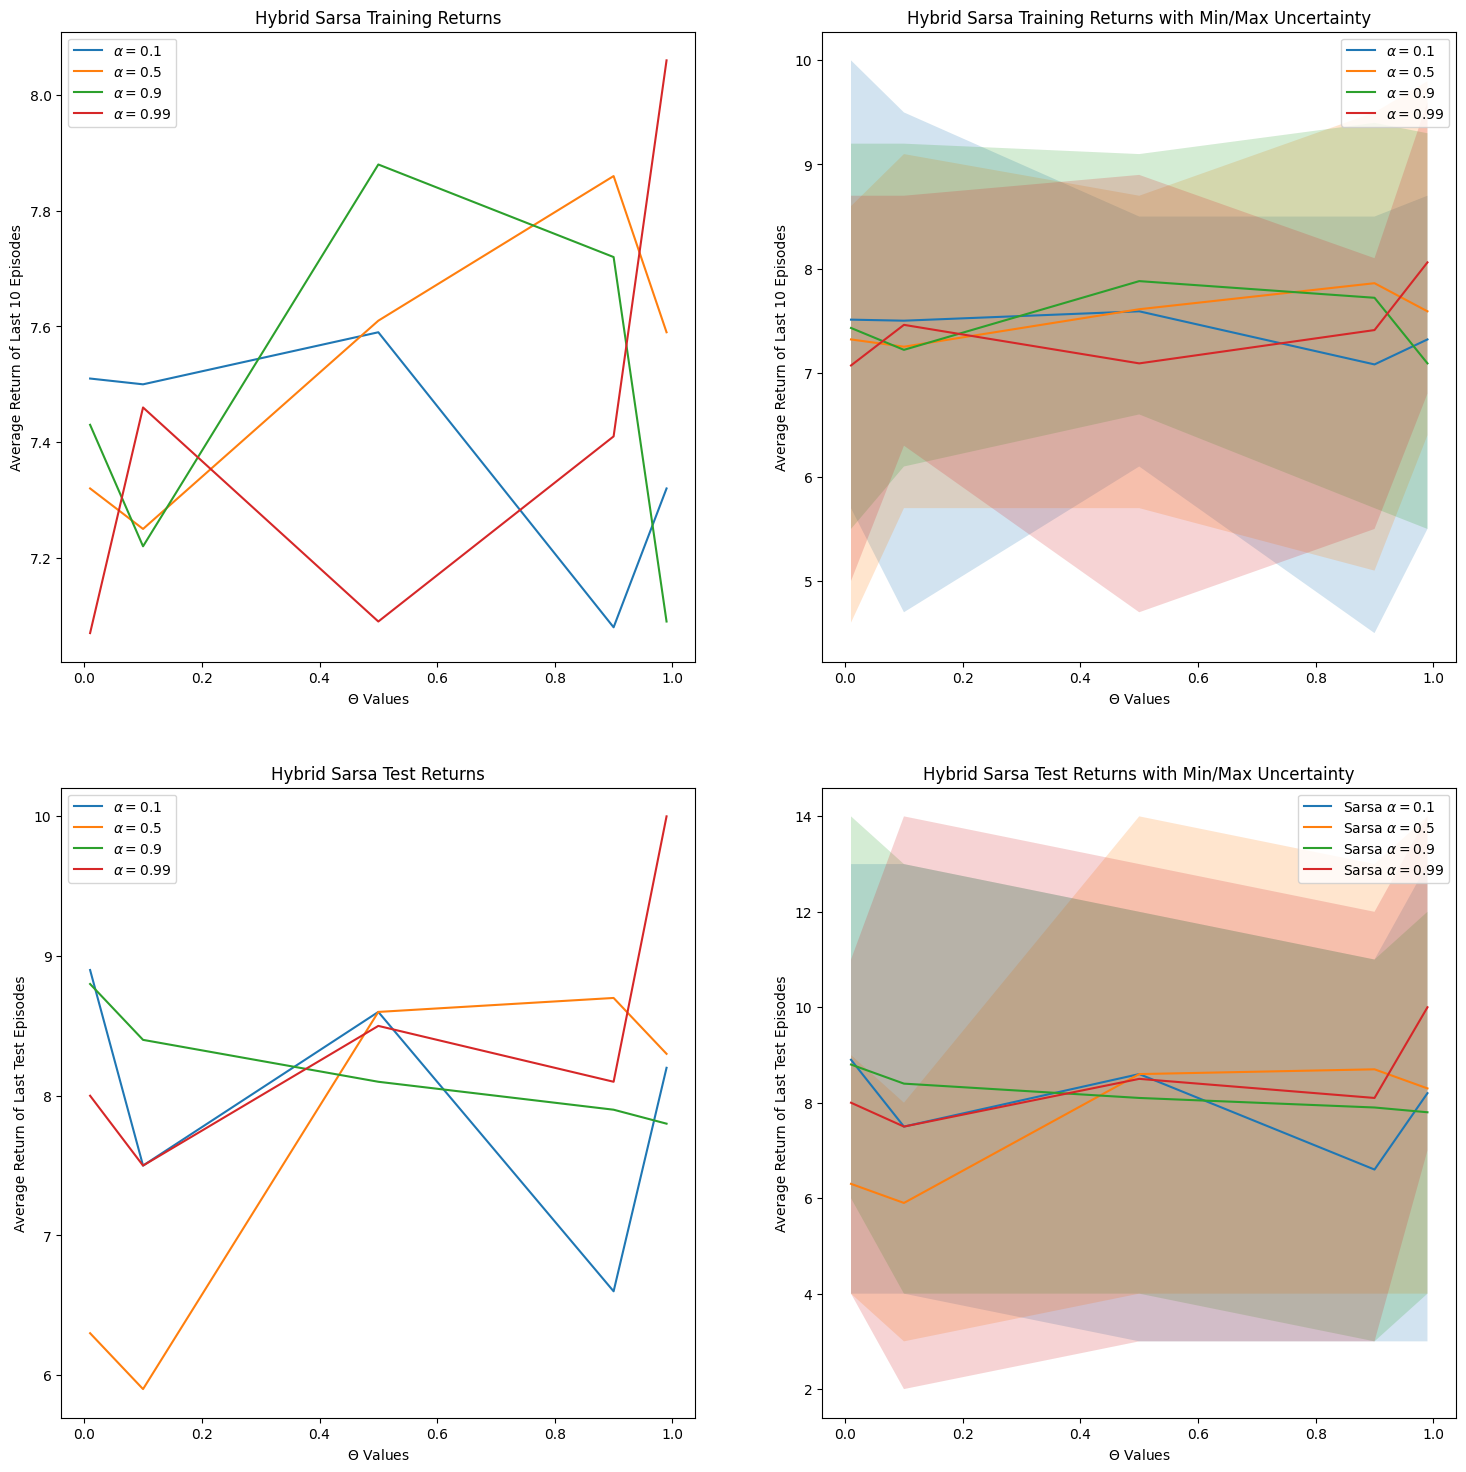

In [ ]:
hybrid_sarsa_experiments_avg_train = np.mean(
    np.mean(hybrid_experiments[:, :, :10], axis=2), axis=1
)
hybrid_sarsa_experiments_max_train = np.max(
    np.mean(hybrid_experiments[:, :, :10], axis=2), axis=1
)
hybrid_sarsa_experiments_min_train = np.min(
    np.mean(hybrid_experiments[:, :, :10], axis=2), axis=1
)

hybrid_sarsa_experiments_avg_test = np.mean(hybrid_experiments[:, :, 10], axis=1)
hybrid_sarsa_experiments_max_test = np.max(hybrid_experiments[:, :, 10], axis=1)
hybrid_sarsa_experiments_min_test = np.min(hybrid_experiments[:, :, 10], axis=1)


fig, ax = plt.subplots(2, 2, figsize=(18, 18))
n = 5

# Training returns without uncertainty
for i in range(len(alphas)):
    alpha = alphas[i]
    ax[0][0].plot(
        thetas,
        hybrid_sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"$\alpha = %s$" % alpha,
    )

ax[0][0].set_title("Hybrid Sarsa Training Returns")
ax[0][0].set_xlabel("$\Theta$ Values")
ax[0][0].set_ylabel("Average Return of Last 10 Episodes")
ax[0][0].legend()

# Training returns with uncertainty
for i in range(len(alphas)):
    alpha = alphas[i]
    ax[0][1].plot(
        thetas,
        hybrid_sarsa_experiments_avg_train[n * i : n * (i + 1)],
        label=r"$\alpha = %s$" % alpha,
    )
    ax[0][1].fill_between(
        thetas,
        hybrid_sarsa_experiments_min_train[n * i : n * (i + 1)],
        hybrid_sarsa_experiments_max_train[n * i : n * (i + 1)],
        alpha=0.2,
    )

ax[0][1].set_title("Hybrid Sarsa Training Returns with Min/Max Uncertainty")
ax[0][1].set_xlabel("$\Theta$ Values")
ax[0][1].set_ylabel("Average Return of Last 10 Episodes")
ax[0][1].legend()

# Test returns without uncertainty
for i in range(len(alphas)):
    alpha = alphas[i]
    ax[1][0].plot(
        thetas,
        hybrid_sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"$\alpha = %s$" % alpha,
    )

ax[1][0].set_title("Hybrid Sarsa Test Returns")
ax[1][0].set_xlabel("$\Theta$ Values")
ax[1][0].set_ylabel("Average Return of Last Test Episodes")
ax[1][0].legend()

# Test returns with uncertainty
for i in range(len(alphas)):
    alpha = alphas[i]
    ax[1][1].plot(
        thetas,
        hybrid_sarsa_experiments_avg_test[n * i : n * (i + 1)],
        label=r"Sarsa $\alpha = %s$" % alpha,
    )
    ax[1][1].fill_between(
        thetas,
        hybrid_sarsa_experiments_min_test[n * i : n * (i + 1)],
        hybrid_sarsa_experiments_max_test[n * i : n * (i + 1)],
        alpha=0.2,
    )

ax[1][1].set_title("Hybrid Sarsa Test Returns with Min/Max Uncertainty")
ax[1][1].set_xlabel("$\Theta$ Values")
ax[1][1].set_ylabel("Average Return of Last Test Episodes")
ax[1][1].legend()

plt.show()

### Graph Analysis

As seen in the first row of graphs, training performances for Hybrid Sarsa seems to be less volatile than training performance for the two other models we trained above (SARSA and Expected SARSA). Moreover, it seems that when $\theta = 0.5$ where the influences of Q-learning and Expected Sarsa are the same when updating the target, the uncertainty of the training performance is lower than when $\theta$ is closer to 0 or 1. Additionnally, the test performance seems to be pretty consistent around taht same point where $\theta = 0.5$.

When $\theta$ gets closer to 0, the update rule for the target is oriented towards Q-learning which seems to provide better testing results when the learning rate $\alpha = 0.1$. However, it is important to note that hyperparameter values of $\theta = 0.99$ and $\alpha = 0.99$ led to the highest average return for both test and training. This also matches our previous results for Expected-SARSA where the best learning rate was found to be $\alpha = 0.99$ This suggests that in the context of this problem, Expected-SARSA performs better than Q-learning and so that an on-policy approach is better.

Further investigation could involve comparing this Hybrid Sarsa to the Q-learning algorithm, as well as the Double Q-learning algorithm. It could also involve understanding why an on-policy approach worked better on this problem.


### Learning curves

To compare all three models, the same combinations are kept for Sarsa, Expected Sarsa and Hybrid SARSA:$ \alpha = 0.5$ and $ \gamma = 0.9$. For Sarsa, we use a 0.9 temperature while for Expected-SARSA we use 0.01. This decision is explained in Question 1, before we generate the learning curves.

Moreover, we keep $\epsilon = 0.01$ for Hybrid SARSA as well and we fix $\theta = 0.5$ to get a perfect combination of Q-learning and Expected SARSA to update the target.

In [ ]:
# Learning Curves

sarsa_returns = []
expected_sarsa_returns = []
hybrid_returns = []
for _ in range(10):
    # Best Sarsa combination
    agent = Sarsa(env, alpha=0.5, gamma=0.9, temp=0.9)
    sarsa_returns.append(run_trial(agent, env, learning_curve=True))
    del agent
    # Best Expected Sarsa combination
    agent = ExpectedSarsa(env, alpha=0.5, gamma=0.9, temp=0.01)
    expected_sarsa_returns.append(run_trial(agent, env, learning_curve=True))
    del agent
    # Best Hybrid Sarsa combination
    agent = Hybrid_Sarsa_Q(env, alpha=0.5, epsilon=0.01, gamma=0.9, theta=0.5)
    ret = run_trial(agent, env, learning_curve=True)
    hybrid_returns.append(ret)
    del agent

sarsa_returns = np.asarray(sarsa_returns)
expected_sarsa_returns = np.asarray(expected_sarsa_returns)
hybrid_returns = np.asarray(hybrid_returns)

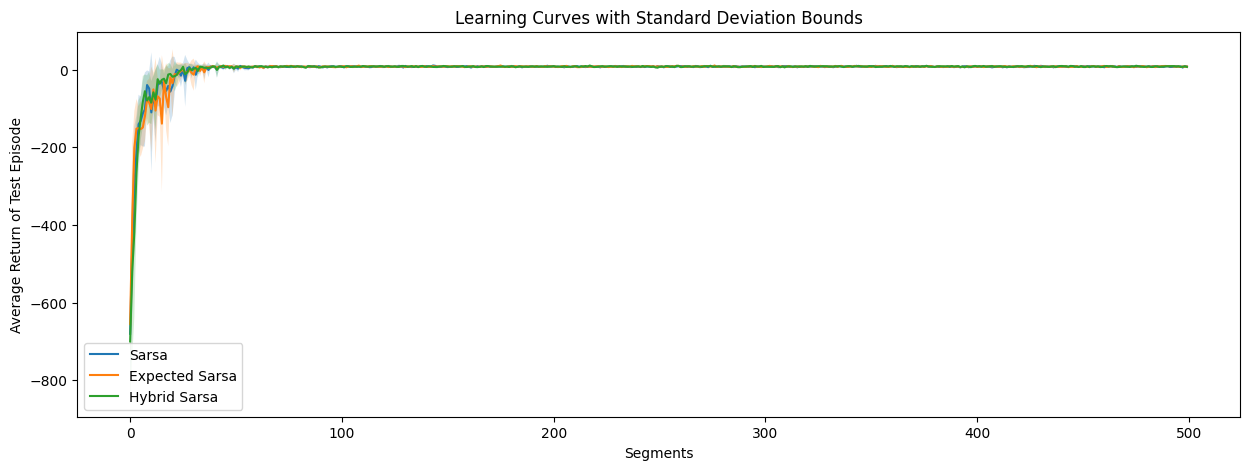

In [ ]:
sarsa_returns_avg = np.mean(sarsa_returns, axis=0)
sarsa_returns_std = np.std(sarsa_returns, axis=0)

expected_sarsa_returns_avg = np.mean(expected_sarsa_returns, axis=0)
expected_sarsa_returns_std = np.std(expected_sarsa_returns, axis=0)

hybrid_sarsa_returns_avg = np.mean(hybrid_returns, axis=0)
hybrid_sarsa_returns_std = np.std(hybrid_returns, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(sarsa_returns_avg, label=r"Sarsa")
ax.fill_between(
    range(len(sarsa_returns_avg)),
    sarsa_returns_avg - sarsa_returns_std,
    sarsa_returns_avg + sarsa_returns_std,
    alpha=0.2,
)
ax.plot(expected_sarsa_returns_avg, label=r"Expected Sarsa")
ax.fill_between(
    range(len(expected_sarsa_returns_avg)),
    expected_sarsa_returns_avg - expected_sarsa_returns_std,
    expected_sarsa_returns_avg + expected_sarsa_returns_std,
    alpha=0.2,
)
ax.plot(hybrid_sarsa_returns_avg, label=r"Hybrid Sarsa")
ax.fill_between(
    range(len(hybrid_sarsa_returns_avg)),
    hybrid_sarsa_returns_avg - hybrid_sarsa_returns_std,
    hybrid_sarsa_returns_avg + hybrid_sarsa_returns_std,
    alpha=0.2,
)

ax.set_title("Learning Curves with Standard Deviation Bounds")
ax.set_xlabel("Segments")
ax.set_ylabel("Average Return of Test Episode")
ax.legend()

plt.show()

As seen in the above graph, Hybrid Sarsa converges as the other two models but seems to do it faster and incorporate less volatility in the first time steps.